In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10,6)}, style="darkgrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Определение упаковки для заказов "один-заказ-один-товар"

Чтение данных

In [2]:
data = pd.read_csv('data/data.csv', index_col=0)\
        .drop(['whs', 'selected_carton', 'sel_calc_cube', 'recommended_carton',
              'pack_volume', 'rec_calc_cube', 'who', 'trackingid', 'recommended_cartontype'], axis=1)
cargotype = pd.read_csv('data/cargotype_sort.csv', index_col=0)
sku_cargotypes = pd.read_csv('data/sku_cargotypes_filtered.csv')#только sku которые есть в data
sku = pd.read_csv('data/sku_filtered.csv')#только sku которые есть в data

Распределение заказов по количеству товаров:

In [3]:
round(data.groupby('orderkey')['sku'].count().value_counts(normalize=True)
            .head(10).reset_index().rename({'index':'goods_amount',
                                           'sku': 'share'}, axis=1),3)

,goods_amount,share
0,1,0.650
1,2,0.167
2,3,0.065
3,4,0.040
4,5,0.024
5,6,0.016
6,7,0.008
7,8,0.006
8,10,0.006
9,9,0.004


Из таблицы выше видно что в 65% заказов у нас всего лишь один товар. Поэтому целесообразно выделить такие заказы в отдельную категорию и для них делать рекомендацию. Около 23% заказов с 2-3 товарами, их мы так же выделим в отдельную категорию. Все остальные заказы будем рассматривать так же отдельно, их доля очень небольшая и здесь будет необходим особый подход. 

Словарь для приведения карготипов к тем которые мы определили 

In [4]:
cargotype_dict = dict(zip(cargotype.cargotype.astype(str), cargotype.sort.astype(str)))
cargotypes = list(set(cargotype_dict.values()))

Выделение из data заказов в которых только один товар

In [5]:
one_item_list = (data.groupby('orderkey')['sku'].count().reset_index()
                 .query('sku==1')['orderkey'].to_list())
data_single = data[data.orderkey.isin(one_item_list)]
print(f'Orders with one item: {data_single.shape[0]}')

Orders with one item: 103970


Какие-то товары занимают больше одной посылки. 

In [6]:
data_single[data_single.box_num != 1].shape[0]

980

Их совсем немного, отбросим их

In [7]:
data_single = data_single[data_single.box_num == 1].drop('box_num', axis=1)

### Признаки для товаров

Для каждого товара у нас есть линейные размеры, вес а так же карготипы. Попробуем использовать все эти признаки для обучения классификатора.

Линейные размеры и вес мы можем использовать как есть, а карготипы закодируем для товаров по принципу One-Hot. И добавим к ним линейные размеры.

In [8]:
sku_cargotypes['cargotype'] = sku_cargotypes.cargotype.\
                            astype(str).map(cargotype_dict)
sku_cargotypes = sku_cargotypes.drop_duplicates()

In [9]:
sku_cargotypes_ohe = pd.crosstab(sku_cargotypes.sku, 
                                 columns=sku_cargotypes.cargotype).reset_index()
sku = sku.merge(sku_cargotypes_ohe, 
                how='left', 
                on='sku').dropna()

Так же добавим дополнительные признаки:
- минимальный и максимальный линейный размеры
- общий объем товара

In [10]:
sku['sku_volume'] = round(sku['a'] * sku['b'] * sku['c'])
sku['min_sku_dim'] = sku[['a', 'b', 'c']].min(axis=1)
sku['max_sku_dim'] = sku[['a', 'b', 'c']].max(axis=1)

И соединим даные о товарах с данными о заказах.

In [11]:
data_single = data_single.merge(sku, on='sku', how='left').dropna()

Теперь посмотрим есть ли у нас неявные дубликаты. Так как это исторические данные и разные упаковщики могли использовать разную упаковку для одних и тех же товаров, то у нас могут быть разные ответы для классификации одних и тех же признаков. 

In [12]:
data_single.groupby('sku')['selected_cartontype'].nunique().value_counts()

1     39093
2      7059
3      1518
4       444
5       156
6        80
7        31
8        10
9         4
11        1
10        1
Name: selected_cartontype, dtype: int64

Видно, что для одних и тех же sku довольно часто использовались разные упаковки. Возможно, это связанно с субъективностью упаковщиков или с какими-то другими обстоятельствами. Так как наша задача это в том числе и минимизация расходов на упаковку, то для товаров которые упаковывали в разные типы упаковок мы будем брать только самую оптимальную(дешевую) предполагая, что раз такую хотя бы однажды использовали, то она подходит для конкретного товара. 

<font size=4>Важный момент!</font>  
Так как упаковщики часто используют совершенно раную упаковку для одних и тех же товаров, мы не можем полагаться на selected_cartontype как на правильный ответ. То есть цель рекомендации не угадать то что выбрал упаковщик когда-либо, а рекомендовать оптимальную упаковку опираясь на выбор упаковщиков, но не считая его единственно верным. Так же мы должны учитывать и другие факторы(например, карготипы).

In [13]:
prices = pd.read_csv('data/carton_price.csv')
prices_dict = dict(zip(prices.cartontype, 
                       prices.price))

Поиск самой выгодной упаковки

In [14]:
def get_cheapest(l:list, 
                 prices:dict=prices_dict)-> str:
    l = list(set(l))
    l = sorted(l, key=lambda x: prices_dict.get(x, 0))
    return l[0]

Все используемые упаковки для товаров

In [15]:
packages = data_single.groupby('sku')['selected_cartontype'].apply(list).reset_index()
packages['selected_cartontype'] = packages['selected_cartontype'].apply(get_cheapest)

Добавим исправленные selected_cartontype в data_single, оригинальные упаковки уберем.

In [16]:
data_single = data_single.drop('selected_cartontype', axis=1)
data_single = data_single.merge(packages, on='sku', how='left')
data_single

,orderkey,goods_wght,sku,a,b,c,0,120,130,200,290,291,292,300,302,303,305,310,320,340,360,40,400,410,440,460,480,485,520,610,620,641,670,700,900,910,950,960,970,sku_volume,min_sku_dim,max_sku_dim,selected_cartontype
0,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3051.0,3.3,49.7,STRETCH
1,3e646181f6f708edd3326c1626c12d23,4.400,ef468fa349bb8f058aa5dcd76bda60b2,30.0,23.0,22.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15180.0,22.0,30.0,STRETCH
2,7047c16a6b7c120162ca3da0ebca43fd,0.700,d714bc5c946ec01d9b09714524805e5c,14.0,10.7,43.8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6561.0,10.7,43.8,STRETCH
3,097917e584151c0c21f205b2c3aafa10,2.078,eb0e661f3ed57ef7ca16418bf50e363e,23.4,8.0,33.9,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6346.0,8.0,33.9,STRETCH
4,1d11d793924acefde0b7f2ad149e1b45,6.020,0588e43ea7ad1ef603059269db6467eb,30.0,47.0,15.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21150.0,15.0,47.0,NONPACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96103,f1a5e5ba97b77db86e1d747d0d4dbbfb,0.129,6f103f2f8f9153f5d63cb095284d6cd8,22.1,4.4,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,681.0,4.4,22.1,MYB
96104,3acc4b901256bcd9f333b6978864773b,1.740,bd4fcd43314a9b3e28cbf7ae22b3ece4,25.0,9.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4050.0,9.0,25.0,YMC
96105,e71d2e750ce9a7a39c273c634be1665d,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3523.0,10.2,30.3,NONPACK
96106,2e2a642f611b5a6f2c404ab945fbc2a3,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,552.0,2.0,23.0,MYB


Проверим дубликаты

In [17]:
data_single.drop(['orderkey'],
                axis=1).duplicated().sum()

47672

Около половины товаров теперь повторяются. Избавимся от дубликатов. 

In [18]:
subset = list(set(data_single.columns) - {'orderkey', 'box_num', 'recommended_cartontype'})
data_single = data_single.drop_duplicates(subset=subset)
data_single.shape

(48436, 43)

И наконец добавим еще один признак - плотность, предполагая что соотношение веса и объема может влиять на выбор упаковки. 

In [19]:
data_single['density'] = round(data_single['goods_wght'] / data_single['sku_volume'],5)

In [20]:
data_single.selected_cartontype.value_counts(normalize=True)

MYB        0.344888
MYC        0.188269
MYA        0.162255
NONPACK    0.090470
MYD        0.076307
STRETCH    0.073582
MYE        0.021162
YMA        0.018602
YMC        0.011624
YMF        0.003200
MYF        0.003159
YMW        0.002911
YMG        0.002643
YME        0.000661
YMX        0.000248
YML        0.000021
Name: selected_cartontype, dtype: float64

Больше 15% товаров не упаковывались вообще или упаковывались в стрейч пленку. Попробуем обучить классификатор и проверить сможем ли мы разделить товары для которых нужна упаковка и товары для которых она не нужна.

### Классификатор для определения нуждается ли товар в упаковке или нет

In [21]:
cb = catboost.CatBoostClassifier(verbose=False, class_weights={0:1,1:8})
skf = StratifiedKFold(n_splits=5, 
                      shuffle=True,
                      random_state=42)

Прометим "1" те заказы где не использовалась упаковка или была использована стрейч пленка. Для остальных поставим "0"

In [22]:
X = data_single.drop(['orderkey', 'sku', 'selected_cartontype'], axis=1)
y = data_single.selected_cartontype.map(lambda x: 1 if x in ['NONPACK', 'STRETCH'] else 0)

Из-за дисбаланса классов а так же из-за невозможности определить порог принятия решения мы будем использовать метрику roc-auc для оценки способности алгоритма разделять классы. 

In [23]:
%%time

cv_scores = cross_validate(cb, X,y, cv=skf, n_jobs=-1,
                           scoring=['roc_auc'])

print('CV mean roc_auc score', round(np.mean(cv_scores['test_roc_auc']),3))

CV mean roc_auc score 0.947
CPU times: user 70.9 ms, sys: 123 ms, total: 194 ms
Wall time: 31 s


Обучим классификатор на всех данных

In [24]:
cb.fit(X,y)

И посмотрим какие признаки оказались наиболее важными для обучения модели

In [25]:
def feature_imp(importances=None):

    feature_imp = pd.DataFrame(sorted(zip(importances, X.columns)), 
                                columns=['Value','Feature'])
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title(f'Catboost feature importances')
    plt.tight_layout()
    plt.show()
    return feature_imp

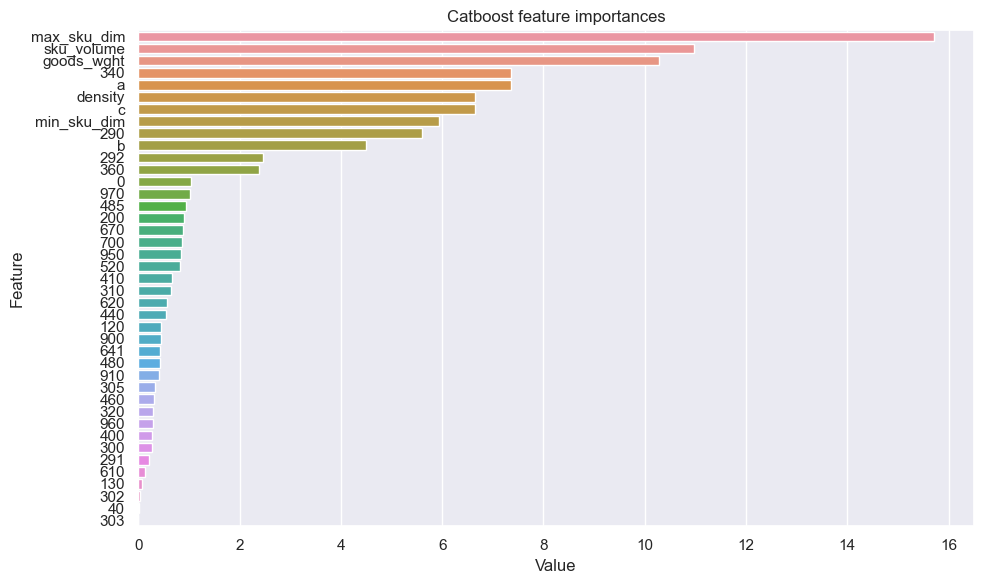

In [26]:
fi = feature_imp(cb.get_feature_importance())

Оставим только самые важные признаки чтобы сделать модель легче

In [27]:
cb_features = ['goods_wght', 'sku_volume', 'min_sku_dim', 
               'max_sku_dim', 'density', 'a', 'b', 'c', 
               '200','290','291','292','320', '340',
               '360','700']
X.columns = list(map(str, X.columns))

In [28]:
cb.fit(X[cb_features], y)

И сохраним эту модель в файле models/catboost_pack_nonpack.pkl

### Рекомендация упаковки в случае если она нужна

Для того, чтобы определять конкретную упаковку для товара мы воспользуемся комбинацией следующих алгоритмов:
 - метод KNN для того чтобы искать ближайших соседей товара среди всех данных по линейным размерам и весу и возвращает вероятности принадлежности к каждому классу
 - алгоритм подбора упаковок для товара по линейным размерам и объему(будем проверять в какие упаковки вообще может поместиться наш товар)

Подготовим модель KNN

In [29]:
#признаки для KNN по которым будет вестись поиск и классификация
knn_features = ['goods_wght','a', 'b', 'c','sku_volume',
                'min_sku_dim', 'max_sku_dim', 'density']

Для KNN целесообразно нормализовать признаки при помощи standard scaler

In [30]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(data_single[knn_features].copy().values)

Словари для кодирования упаковок

In [31]:
packages = data_single.selected_cartontype.unique()
pack_dict = dict(zip(packages, range(len(packages))))
pack_dict.update({'YML':14})
pack_dict_inv = {v:k for k,v in pack_dict.items()}

y = data_single.selected_cartontype.map(pack_dict)

In [32]:
%%time
knn_clf = KNeighborsClassifier(n_neighbors=25, 
                           n_jobs=-1, 
                           weights='uniform',
                           metric='minkowski',
                           algorithm='auto')

cv_scores = cross_validate(knn_clf, X_scaled, y, cv=5, n_jobs=-1,
                           scoring=['roc_auc_ovr'])
print('roc:', np.mean(cv_scores['test_roc_auc_ovr']))

roc: 0.7446208172158547
CPU times: user 32.3 ms, sys: 16.9 ms, total: 49.2 ms
Wall time: 2.74 s


In [33]:
knn_clf.fit(X_scaled, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=25)

Классификатор KNN вместе со StandardScaler и pack_dict_inv сохраним в файл knn_scaler_dict.pkl

В целом KNN довольно плохо справляется с задачей. Но мы и так знали что классы плохо разделимы, поэтому ответы KNN мы будем использовать как дополнительные, и плюс будем брать топ 3 похожих товара. 

In [34]:
def get_knn_top(sample:np.array, k:int=3, th:float=0.2)-> list:
    """Gets features of sku and returns top k appropriate packs.
    Based on a pretrained KNNClassifier.
    Scale the features using StandardScaler.

    Parameters
    ----------
    sample : np.array

    k : int
         (Default value = 3)
         Number of most relevant neighbours

    th : float
         (Default value = 0.2)
         A threshold used to cut off the values
         with the score less than threshold

    Returns
    -------
    top : list
        List of recommended packs

    """
    sample_for_knn = std_scaler.transform(sample.values)
    preds_knn_probas = knn_clf.predict_proba(sample_for_knn)[0]
    probs_packs = [(p,pack_dict_inv[cl]) for p,cl in zip(preds_knn_probas, knn_clf.classes_)]
    knn_recommendations = sorted(probs_packs, reverse=True)
    top = [pack[1] for pack in knn_recommendations if pack[0] >= th]
    
    return top[:k]

Импортируем модуль packer для рекомендации упаковки исходя из габаритов товара(это наш алгоритмический подход), а так же функцию get_cheapest которая подбирает самую дешевую упаковку из рекомендованных.

У нас часто будут встречаться случаи когда подходит несколько упаковок на основании рекомендации KNN и на основании алгоритма проверки размеров. В таких случаях мы будем рекомендовать самую дешевую(и, значит, самую маленькую) упаковку для минимизации затрат на упаковку и логистику(экономия места в транспорте)

In [35]:
from packer import get_packed
from utils import get_cheapest

Для тестирования определим функцию которая будет создавать словарь с заказом, такого же вида как это будет приходить через API:

```
{'orderId': str,
 'items': [{
   'goods_wght': float,
   'sku': str,
   'a': float,
   'b': float,
   'c': float,
   'cargotypes': List[float],
   'count': int
   }]}
```

In [36]:
def get_json_sample(sample:pd.DataFrame)-> dict:
    """Get a json-style sample from dataset"""
    order = dict(zip(sample, sample.values[0]))
    order['cargotypes'] = [k for k,v in order.items() 
                           if (v==1 and k not in ['a','b','c','goods_wght'])]
    order = {k:v for k,v in order.items() if k not in cargotypes}
    order['count'] = 1
    data = {"orderId": order.pop('orderkey'),
        "items": [order]}
    return data


In [37]:
data_single_test = data_single.drop(['sku_volume', 
                                     'min_sku_dim',
                                     'max_sku_dim',
                                     'density',
                                     'selected_cartontype'], axis=1)
data_single_test.columns = list(map(str, data_single_test.columns))
get_json_sample(data_single_test.sample(1))

{'orderId': 'db32898024acfe704c28f14c78e588e0',
 'items': [{'goods_wght': 0.26,
   'sku': 'f03a7ac61fec75d77df7b84d72418eb8',
   'a': 7.0,
   'b': 9.0,
   'c': 7.0,
   'cargotypes': ['0', '290', '410', '700', '900'],
   'count': 1}]}

И функция которая будет подготавливать признаки для моделей. 

In [38]:
def get_features(query:dict, dataframe=True)->pd.DataFrame:
    """Prepares the features for models.
    Return either a pandas DataFrame for catboost and KNN or a dict 
    """
    item = query['items'][0].copy()
    item['sku_volume'] = round(item['a']*item['b']*item['c'], 2)
    item['min_sku_dim'] = min([item['a'],item['b'],item['c']])
    item['max_sku_dim'] = max([item['a'],item['b'],item['c']])
    item['density'] = round(item['goods_wght'] / item['sku_volume'], 2)
    if not dataframe:
        item.pop('cargotypes')
        item.pop('count')
        return item
        
    item['cargotypes'] = list(set(map(lambda x: cargotype_dict.get(int(x),0), 
                                      item['cargotypes'])))
    
    for cargotype in cargotypes:
        item[cargotype] = (int(cargotype) in item['cargotypes']) * 1
        
    item.pop('cargotypes')
    item.pop('count')
    return pd.DataFrame(item, index=[0])

In [39]:
get_features(get_json_sample(data_single_test.sample(1))).columns

Index(['goods_wght', 'sku', 'a', 'b', 'c', 'sku_volume', 'min_sku_dim',
       'max_sku_dim', 'density', '360', '950', '970', '302', '410', '340',
       '520', '670', '0', '620', '910', '300', '480', '120', '40', '485',
       '900', '303', '400', '440', '960', '292', '610', '290', '200', '130',
       '305', '641', '310', '700', '291', '799', '320', '460'],
      dtype='object')

### Проверка алгоритма KNN

Проверим на 5 тысячах сэмплов как часто у нас пересекаются рекомендации KNN и топ 3 результатов алгоритмическолго подбора:

In [40]:
data_single_test_knn = (data_single[~data_single.selected_cartontype.isin(['STRETCH', 'NONPACK'])]
                       .drop(['sku_volume',	'min_sku_dim', 
                              'max_sku_dim', 'selected_cartontype', 
                              'density'], axis=1))

In [41]:
n_samples = 5_000
test_results = []
for _ in tqdm(range(n_samples)):
    # случайный заказ
    sample = get_json_sample(data_single_test_knn.sample(1))
    #результат knn
    knn_rec = get_knn_top(get_features(sample)[knn_features])
    # топ 3 самых дешевых упаковки из подбора алгоритма
    algo_rec = get_packed(sample)[0][:3]
    # есть ли пересечения множеств
    test_results.append(set(knn_rec) & set(algo_rec) != set())
    
print(f'Share of matches between knn and algo: {np.mean(test_results):.2f}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Share of matches between knn and algo: 0.93


Так как у нас около 30% товаров с карготипами не требующими упаковки все-таки упаковывались в пакеты или коробки(что считается нецелесообразным), то проверить алгоритм на точность не представляется возможным. Однако стоит отметить что тест проведенный выше говорит о том что Алгоритм KNN предлагает упаковку которая в 93-95% случаев совпадает с топ-3 из определения самой дешевой из подходящих.

### Финальный алгоритм рекоммендации упаковки

Наконец, определим алгоритм определения упаковки:
1. Сначала для карготипов не требующих упаковки делаем проверку на принадлежность товара к ним
2. Определяем карготипы для которых точно нужна упаковка
3. Если никакие из условий выше не сработали, запускаем классификатор для предсказания необходимости упаковки
4. Если упаковка нужна, ищем упаковки для соседей при помощи KNN и определяем все упаковки в которые может поместиться товар
5. Для некоторых карготипов определяем что нужна только коробка или только пакет
6. Если такого условия нет, то берем самую дешевую из подходящих упаковок

In [42]:
boxes = ['YMA', 'YMC', 'YME', 'YMF', 'YMG', 'YMH', 'YMJ',
         'YML', 'YMN', 'YMO', 'YMP', 'YMQ', 'YMR',  'YMS',
         'YMU', 'YMV', 'YMW',  'YMХ', 'YMX', 'YMY']

packages = ['MYF', 'MYA', 'MYB', 'MYC', 'MYD', 'MYE']

In [43]:
def predict(query:dict)->str:
    """ Recommends the carton type for the sku
    """
    # из исходного запроса с заказом выделяем список с карготипами
    item_cargotypes = query['items'][0]['cargotypes']
    # 340 - не требует упаковки 
    # 292 - крупногабаритный товар
    if ('340' in item_cargotypes or
        '292' in item_cargotypes):
        return 'NONPACK'
    # 360 - требует упаковку в пленку
    if '360' in item_cargotypes:
        return "STRETCH"
    pack_need = False
    # Для всех этих карготипов считаем что нужна упаковка
    # 950 пачкается и мокрое 
    # 700 продукты питания 
    # 460 пахучий 
    # 960 впитывает запах 
    # 40 дорогие вещи 
    if set(item_cargotypes)&set(['950', '700', '460', '960', '60']):
        pack_need = True
    # формируем признаки для catboost
    sample = get_features(query)
    # если по первичным карготипам считаем что упаковка не нужна, то 
    # запускаем классификатор
    if not pack_need:
        pack_need_cb = cb.predict(sample[cb_features])
        if not pack_need_cb:
            return 'NONPACK'
    # в случае если упаковка нужна, ищем соседей с KNN
    knn_ans = get_knn_top(sample[knn_features])
    # а так же берем топ 3 самых дешевых из упаковок которые подходят по размеру
    item = get_features(query, dataframe=False)
    algo_ans = get_packed(query)[0][:3]
    # и берем объединение множеств
    knn_algo_union = set(algo_ans)|set(knn_ans)
    #если в объединении только один ответ - выдаем его 
    if len(knn_algo_union)==1:
        return list(knn_algo_union)[0]
    # проверям тип рекомендуемой упаковки
    pack_type = None
    # хрупкое только в коробки 310
    if set(item_cargotypes)&set(['310']):
        pack_type = boxes
    # пахучее и пачкающееся - в пакеты 950, 460
    if set(item_cargotypes)&set(['950', '460']):
        pack_type = packages
    if pack_type:
        ans = get_cheapest(set([pack for pack in knn_algo_union if pack in pack_type]))
        if ans: #ответ в объединении knn и алго
            return ans
        # ответа нет в объединении - ищем во всех подходящих по размерам
        ans = get_cheapest(set([pack for pack in  get_packed(query) if pack in pack_type]))
        return ans
    # если коробка или пакет не так однозначно определены, то
    # берем самое дешевое из подходящих
    return get_cheapest(knn_algo_union)

Так как мы знаем, что часто упаковщики используют упаковку бОльшего размера чем могли бы(а значит и более дорогую), мы можем сравнить выбор упаковщиков и предложение нашей модели.
Для оценки качества алгоритма мы можем проверить насколько снижается себестоимость упаковки в отличае от использованной упаковщиками. Так же мы сравним насколько изменилась стоимость рекомендованной упаковки по сравнению с текущей моделью(recommended_cartontype)

In [44]:
data = (pd.read_csv('data/data.csv', index_col=0)
        [['orderkey','selected_cartontype','recommended_cartontype']])

Возьмем 10 тысяч случайных заказов для сравнения

In [45]:
n_samples = 10_000
pred_prices, rec_prices, sel_prices = [],[],[]
for _ in tqdm(range(n_samples)):
    sample = get_json_sample(data_single_test.sample(1))
    # упаковка выбранная упаковщиком
    sel_cart = data[data.orderkey==sample['orderId']]['selected_cartontype'].values[0]
    sel_prices.append(prices_dict.get(sel_cart, 1))
    #упаковка рекомендованная текущей моделью
    rec_cart = data[data.orderkey==sample['orderId']]['recommended_cartontype'].values[0]
    rec_prices.append(prices_dict.get(rec_cart, 1))
    #упаковка рекомендованная новой моделью
    pred_cart = predict(sample)
    pred_prices.append(prices_dict.get(pred_cart, 1))

  0%|          | 0/10000 [00:00<?, ?it/s]

И посчитаем метрику MAPE для сравнения рекомендаций нашей модели, рекомендаций текущего алгоритма и упаковки выбранной упаковщиками. Тут стоит отметить что в нашем случае эта метрика работает как бы в обратрую сторону - наша задача снизить себестоимость упаковки по сравнению с рекомендованной и с выбранной упаковщиками. 

In [46]:
# сравнение с рекомендованной упаковкой
round(mape(rec_prices, pred_prices),3)

0.628

In [47]:
# сравнение с выбранной упаковкой
round(mape(sel_prices, pred_prices),3)

0.503

То есть подводя итог можно сказать что наша рекомендация в среднем снижает стоимость упаковки на 62% по сравнению с рекомендациями текущего алгоритма и на 50% в сравнении с упаковкой выбранной упаковщиками. 

## Итог:

Мы разработали алгоритм рекомендации упаковки для заказов с одним товаром использую многоступенчатые фильтры и использую различные подходы для рекомендации упаковки. Был сделан упор на минимизацию себестоимости упаковки, однако мы учитывали дополнительные вводные(карготипы) для обеспечения сохранности товаров при транспортировке. Из анализа упаковок мы знаем что чем меньше цена тем меньше и объем занимаемый упаковкой в транспорте. Таким образом мы снижаем не только себестоимость упаковочных материалов, но и затраты на логистику. 